# Atomic atomisation energies

## CM - without splitting by element

In [1]:
import numpy as np
import qml
import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies/')
import qml_interface as qmi
import utils_qm as uq

import sklearn.model_selection as sk
import pickle

from matplotlib import pyplot as plt


In [2]:
def wrapper_local_idx(global_idx, molecule_sizes):
    item = qmi.get_local_idx([global_idx], molecule_sizes)
    return item

def get_mol_atom_map(molecule_sizes):
    mol_atom_map = dict()
    mol_ids = np.arange(len(molecule_sizes))
    for mid in mol_ids:
        item = wrapper_local_idx(mid, molecule_sizes)
        mol_atom_map[mid] = item
    return(mol_atom_map)

def split_train_test_indices(molecule_sizes, tr_size):
    """
    split indices of atoms in training and test, such that all atoms of a molecule are either in training or test set
    """
    # split molecules by index
    mol_ids = np.arange(len(molecule_sizes))
    splitted_mol_ids = sk.train_test_split(mol_ids,mol_ids,train_size=tr_size)
    mol_id_tr = splitted_mol_ids[0]
    mol_id_test = splitted_mol_ids[1]
    
    # dictionary key:mol index, item:atom indices
    mol_atom_map = get_mol_atom_map(molecule_sizes)
    
    indices_tr = []
    for idx in mol_id_tr:
        indices_tr.extend(mol_atom_map[idx])
        
    indices_test = []
    for idx in mol_id_test:
        indices_test.extend(mol_atom_map[idx])
    return(indices_tr, indices_test, mol_id_test)

def split_molecule_wise(reps, labels, tr_size, molecule_sizes):
    """
    molecules_sizes: numpy 1D-array; contains the lengths of the molecules in the training data
    """
    
    # split only atomic indices
    indices_tr, indices_test, mol_id_test = split_train_test_indices(molecule_sizes, tr_size)
    
    # split reps, labels into training/test using indices
    reps_tr = reps[indices_tr]
    reps_test = reps[indices_test]
    labels_tr = labels[indices_tr]
    labels_test = labels[indices_test]
    
    return(reps_tr, reps_test, labels_tr, labels_test, mol_id_test)

def predict_labels_mol(reps_tr,sigma, coeffs, mol_id_test, mol_atom_map, reps):
    labels = []
    for i in mol_id_test:
        reps_test_mol = reps[mol_atom_map[i]]
        labels_in_mol = qmi.predict_labels(reps_test_mol, reps_tr, sigma, coeffs)
        labels.append(labels_in_mol.sum())
    return(labels)
        
def get_labels_mol_test(labels, mol_id_test, mol_atom_map):
    # per molecule

    labels_mol_test = []
    for idx in mol_id_test:
        idc = mol_atom_map[idx]
        labels_mol_test.append(labels[idc].sum())
    
    return(np.array(labels_mol_test) )
        

def crossvalidate_moleculewise(reps, labels, tr_size, sigma, lam, num_cv, molecule_sizes):
    errors = []
    errors_per_mol = []
    for cv in range(num_cv):
        reps_tr, reps_test, labels_tr, labels_test, mol_id_test = split_molecule_wise(reps, labels, tr_size, molecule_sizes)
        
        coeffs = qmi.train_kernel(reps_tr, labels_tr, sigma, lam_val)
        labels_predicted = qmi.predict_labels(reps_test, reps_tr, sigma, coeffs)
        errors.append((np.abs(labels_predicted - labels_test)).mean())

        
        mol_atom_map = get_mol_atom_map(molecule_sizes)
        labels_predicted_mol = predict_labels_mol(reps_tr,sigma, coeffs, mol_id_test, mol_atom_map, reps)
        labels_mol_test = get_labels_mol_test(labels, mol_id_test, mol_atom_map)
        errors_per_mol.append( (np.abs(labels_predicted_mol-labels_mol_test)).mean() )

    errors = np.array(errors)
    errors_per_mol = np.array(errors_per_mol)
    return(errors.mean(), errors.std(), errors_per_mol.mean(), errors_per_mol.std())

### Learning curves calculation

In [3]:
# data preparation
data, molecule_sizes = qmi.load_alchemy_data(qmi.wrapper_alch_data())
labels = qmi.generate_label_vector(data, molecule_sizes.sum(), value='alch_pot')

all_local_reps = qmi.generate_atomic_representations(data, molecule_sizes)

In [4]:
### Labels = $\mu(\lambda = 1)$ from pyscf

In [5]:
files_alch = []
with open('/home/misa/projects/Atomic-Energies/data/vacuum_reference/qm9_data/alchpots_lam1.txt', 'r') as f:
    for l in f:
        files_alch.append(l.strip('\n'))
labels = []
for p in files_alch:
    labels.extend(np.load(p))
labels = np.array(labels)

In [6]:
# for mu opt sigma = 48.50293012833276
# for atomic opt sigma = 222.8609442038079
# for atomic atomisation opt sigma = 222.8609442038079

opt_sigma = 48.50293012833276 # best sigma from hyperparameter optimization
lam_val = 1e-5
num_cv = 3

# define number of training points for which MAE is calculated
set_sizes = np.logspace(0, 9, 10, base=2).astype(int)
set_sizes = np.concatenate((set_sizes, np.array([900])))

error_cv = []
error_std = []

error_cv_mol = []
error_std_mol = []

# calculate error for every training point size
for idx, tr_size in enumerate(set_sizes):
    err, err_std, err_mol, err_std_mol = crossvalidate_moleculewise(all_local_reps, labels, tr_size, opt_sigma, lam_val, num_cv, molecule_sizes)
    error_cv.append(err)
    error_std.append(err_std)
    error_cv_mol.append(err_mol)
    error_std_mol.append(err_std_mol)
    
lcurves = np.array([set_sizes, error_cv, error_std]).T
lcurves_mol = np.array([set_sizes, error_cv_mol, error_std_mol]).T

In [7]:
np.savetxt('/home/misa/projects/Atomic-Energies/data/lcurves/lcurves_alch_pot/only_lambda1/pyscf.txt', lcurves)
np.savetxt('/home/misa/projects/Atomic-Energies/data/lcurves/lcurves_alch_pot/only_lambda1/pyscf_per_mol.txt', lcurves_mol)

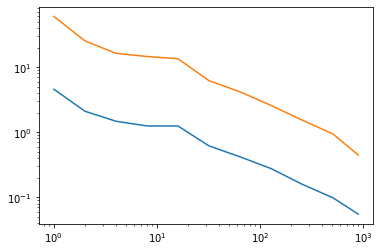

In [9]:
plt.plot(lcurves[:,0], lcurves[:,1])
plt.plot(lcurves_mol[:,0], lcurves_mol[:,1])

plt.xscale('log')
plt.yscale('log')

In [ ]:
lcurves[:,1]

### Hyperparameter optimization

In [ ]:
# data preparation
data, molecule_sizes = qmi.load_alchemy_data(qmi.wrapper_alch_data())
#labels = qmi.generate_label_vector(data, molecule_sizes.sum(), value='atomisation')

all_local_reps = qmi.generate_atomic_representations(data, molecule_sizes)

In [ ]:
files_alch = []
with open('/home/misa/projects/Atomic-Energies/data/vacuum_reference/qm9_data/alchpots_lam1.txt', 'r') as f:
    for l in f:
        files_alch.append(l.strip('\n'))
labels = []
for p in files_alch:
    labels.extend(np.load(p))
labels = np.array(labels)

In [ ]:
sigmas = np.logspace(-1, 10, 11, base=2)
lam_val = 1e-5
num_cv = 3

lcurves = dict()
lcurves_mol = dict()

# define number of training points for which MAE is calculated
#set_sizes = #np.logspace(0, 9, 10, base=2).astype(int)
set_sizes = [900]#np.concatenate((set_sizes, np.array([900])))

for sigma in sigmas:
    error_cv = []
    error_std = []
    
    error_cv_mol = []
    error_std_mol = []
    
    # calculate error for every training point size
    for idx, tr_size in enumerate(set_sizes):
        err, err_std, err_mol, err_std_mol = crossvalidate_moleculewise(all_local_reps, labels, tr_size, sigma, lam_val, num_cv, molecule_sizes)
        error_cv.append(err)
        error_std.append(err_std)
        error_cv_mol.append(err_mol)
        error_std_mol.append(err_std_mol)
    
    lcurves[f'sig_{sigma}'] = np.array([set_sizes, error_cv, error_std]).T
    lcurves_mol[f'sig_{sigma}'] = np.array([set_sizes, error_cv_mol, error_std_mol]).T

In [ ]:
fname = '/home/misa/projects/Atomic-Energies/data/lcurves/lcurves_atomisation/opt_sigma_all_atomic_atomisation.txt'
np.savetxt(fname, lcurves)
fname_mol = '/home/misa/projects/Atomic-Energies/data/lcurves/lcurves_atomisation/opt_sigma_all_atomic_atomisation_per_molecule.txt'
np.savetxt(fname_mol, lcurves_mol)

In [ ]:
fname = '/home/misa/projects/Atomic-Energies/data/lcurves/lcurves_atomisation/all_sigmas_all_atomic_atomisation'
uq.save_obj(lcurves, fname)

fname_mol = '/home/misa/projects/Atomic-Energies/data/lcurves/lcurves_atomisation/all_sigmas_all_atomic_atomisation_per_molecule'
uq.save_obj(lcurves_mol, fname_mol)

## Elementwise learning

In [ ]:
import numpy as np
import sklearn.model_selection as sk

import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies/')

import qml_interface as qmi

In [ ]:
def split_molecule_indices(num_data_pts, tr_size):
    molecule_indices = np.arange(num_data_pts)
    tr_indices_mol, test_indices_mol, dummy1, dummy2 = sk.train_test_split(molecule_indices,molecule_indices,train_size=tr_size)
    return(tr_indices_mol, test_indices_mol)

def sort_indices_by_element(indices, charges):
    """
    list of charges; charges[i] is the charge of the atom with index i
    """
    unique_charges = list(set(charges))
    unique_charges.sort()
    indices_by_charge = {k: [] for k in unique_charges}

    for index in indices:
        ch = charges[index]
        indices_by_charge[ch].append(index)
    return(indices_by_charge)

def get_error_per_molecule(charges, labels_test_by_charge, molecule_sizes, prediction_by_charge, test_indices_by_charge, test_indices_mol):
    # error per molecule
    prediction_per_molecule = []
    label_per_molecule = []

    # get the predictions molecule wise
    for mol_id in test_indices_mol:
        # atomic indices for atoms in test molecule
        atomic_indices_molecule = qmi.get_local_idx([mol_id], molecule_sizes)
        # sort atomic indices of test molecule by charge (then I know where to look for position of index after splitting by charge)
        atomic_indices_molecule_splitted_by_charge = sort_indices_by_element(atomic_indices_molecule, charges)
        # find position of atomic indices in the *_by_charge lists
        unique_charges = list(set(charges))
        unique_charges.sort()
        final_atomic_indices_by_charge = {k: [] for k in unique_charges}
        for k in atomic_indices_molecule_splitted_by_charge.keys():
            tmp_list = atomic_indices_molecule_splitted_by_charge[k]
            for index in tmp_list:
                final_atomic_indices_by_charge[k].append(test_indices_by_charge[k].index(index))
        # get the prediction and the label
        atomic_atomisation_energies_predicted = []
        atomic_atomisation_energies_true = []
        for k in final_atomic_indices_by_charge.keys():
            tmp_list = final_atomic_indices_by_charge[k]
            atomic_atomisation_energies_predicted.extend(prediction_by_charge[k][tmp_list])
            atomic_atomisation_energies_true.extend(labels_test_by_charge[k][tmp_list])

        atomic_atomisation_energies_predicted = np.array(atomic_atomisation_energies_predicted)
        prediction_per_molecule.append(atomic_atomisation_energies_predicted)

        atomic_atomisation_energies_true = np.array(atomic_atomisation_energies_true)
        label_per_molecule.append(atomic_atomisation_energies_true)
    return(prediction_per_molecule, label_per_molecule)

def train_test_cycle_by_charge(all_local_reps, charges, labels, lam_val_by_charge, molecule_sizes, sigma_by_charge, tr_size):
    """
    calculate MAE for a randomly selected training set for given hyperparameters
    """
    ####################################
    # split data in test and training
    ####################################
    
    # first split molecules
    data_size = len(molecule_sizes)
    tr_indices_mol, test_indices_mol = split_molecule_indices(data_size, tr_size)
    
    # get atom indices from molecule indices
    tr_indices_atom = qmi.get_local_idx(tr_indices_mol, molecule_sizes)
    test_indices_atom = qmi.get_local_idx(test_indices_mol, molecule_sizes)
    
    # split atomic indices by charge
    tr_indices_by_charge = sort_indices_by_element(tr_indices_atom, charges)
    test_indices_by_charge = sort_indices_by_element(test_indices_atom, charges)
    
#     # debug
#     for k in tr_indices_by_charge.keys():
#         print(len(tr_indices_by_charge[k]))
    
    # sort training and test atomic representations by charge
    reps_tr_by_charge = dict()
    for k in tr_indices_by_charge.keys():
        reps_tr_by_charge[k] = all_local_reps[tr_indices_by_charge[k]]

    reps_test_by_charge = dict()
    for k in test_indices_by_charge.keys():
        reps_test_by_charge[k] = all_local_reps[test_indices_by_charge[k]]
        
    # sort training and test atomic labels by charge
    labels_tr_by_charge = dict()
    for k in tr_indices_by_charge.keys():
        labels_tr_by_charge[k] = labels[tr_indices_by_charge[k]]

    labels_test_by_charge = dict()
    for k in test_indices_by_charge.keys():
        labels_test_by_charge[k] = labels[test_indices_by_charge[k]]
        
        
    ####################################
    # train and test individual elements
    ####################################
    
    # train elementwise
    coeffs_by_charge = dict()
    for k in reps_tr_by_charge.keys():
        coeffs_by_charge[k] = qmi.train_kernel(reps_tr_by_charge[k], labels_tr_by_charge[k], sigma_by_charge[k], lam_val_by_charge[k])
        
    # predict elementwise
    prediction_by_charge = dict()
    for k in reps_tr_by_charge.keys():
        prediction_by_charge[k] = qmi.predict_labels(reps_test_by_charge[k], reps_tr_by_charge[k], sigma_by_charge[k], coeffs_by_charge[k])
        
    # test error per atom
    error_by_charge = dict()
    for k in labels_test_by_charge.keys():
        error_by_charge[k] = (np.abs(prediction_by_charge[k]-labels_test_by_charge[k])).mean()
    
    ####################################
    # test per molecule
    ####################################
    # get moleculewise prediction
    prediction_per_molecule, label_per_molecule = get_error_per_molecule(charges, labels_test_by_charge, molecule_sizes, prediction_by_charge, test_indices_by_charge, test_indices_mol)
    # calculate error
    error_per_molecule = []
    for p, t in zip(prediction_per_molecule, label_per_molecule):
        error_per_molecule.append((p-t).sum())
    error_per_molecule = np.array(error_per_molecule)
    mae_molecule = np.abs(error_per_molecule).mean()
    
    return(mae_molecule, error_by_charge)
    

In [ ]:
# data preparation
paths = qmi.wrapper_alch_data()
exclude='/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/dsgdb9nsd_000829/atomic_energies_with_mic.txt'
paths.remove(exclude)
data, molecule_sizes = qmi.load_alchemy_data(paths)
labels = qmi.generate_label_vector(data, molecule_sizes.sum(), value='atomisation')
charges = qmi.generate_label_vector(data, molecule_sizes.sum(), value='charge')

all_local_reps = qmi.generate_atomic_representations(data, molecule_sizes)

In [ ]:
lam_val_by_charge = {1.0:1e-5, 6.0:1e-5, 7.0:1e-5, 8.0:1e-5}
sigma_by_charge = {1.0:223, 6.0:223, 7.0:223, 8.0:223}
tr_sizes = [64, 128, 256, 512, 900]
num_cv = 3

In [ ]:
lcurve_mol = []

unique_charges = list(set(charges))
unique_charges.sort()
lcurve_by_charge = {k: [] for k in unique_charges}

for tr_size in tr_sizes:
    error_mol = []
    unique_charges = list(set(charges))
    unique_charges.sort()
    error_by_charge = {k: [] for k in unique_charges}

    for cv in range(num_cv):
        error_mol_tmp, error_by_charge_tmp = train_test_cycle_by_charge(all_local_reps, charges, labels, lam_val_by_charge, molecule_sizes, sigma_by_charge, tr_size)
        error_mol.append(error_mol_tmp)
        for k in error_by_charge_tmp.keys():
            error_by_charge[k].append(error_by_charge_tmp[k])

    mae_mol = (np.array(error_mol)).mean()
    std_mol = (np.array(error_mol)).std()
    mae_by_charge = dict()
    std_by_charge = dict()
    for k in error_by_charge.keys():
        mae_by_charge[k] = (np.array(error_by_charge[k])).mean()
        std_by_charge[k] = (np.array(error_by_charge[k])).std()
        
    lcurve_mol.append([tr_size, mae_mol, std_mol])
    for k in lcurve_by_charge.keys():
        lcurve_by_charge[k].append([tr_size, mae_by_charge[k], std_by_charge[k]])

In [ ]:
path_mol = '/home/misa/projects/Atomic-Energies/data/lcurves/lcurves_atomisation/atomic_atomisation_elementwise_per_molecule.txt'
np.savetxt(path_mol, lcurve_mol)

for k in lcurve_by_charge.keys():
    path_atomic = f'/home/misa/projects/Atomic-Energies/data/lcurves/lcurves_atomisation/atomic_atomisation_elementwise_Z_{k}.txt'
    np.savetxt(path_atomic, lcurve_by_charge[k])

### Optimize hyperparameters

In [ ]:
# data preparation
paths = qmi.wrapper_alch_data()
exclude='/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/dsgdb9nsd_000829/atomic_energies_with_mic.txt'
paths.remove(exclude)
data, molecule_sizes = qmi.load_alchemy_data(paths)
labels = qmi.generate_label_vector(data, molecule_sizes.sum(), value='atomisation')
charges = qmi.generate_label_vector(data, molecule_sizes.sum(), value='charge')

all_local_reps = qmi.generate_atomic_representations(data, molecule_sizes)

In [ ]:
lam_val_by_charge = {1.0:1e-5, 6.0:1e-5, 7.0:1e-5, 8.0:1e-5}
sigmas = np.logspace(-1, 10, 11, base=2)
tr_size = 900
num_cv = 3

In [ ]:
lcurve_mol = []

unique_charges = list(set(charges))
unique_charges.sort()
mae_sigma_by_charge = {k: [] for k in unique_charges}

for s in sigmas:
    sigma_by_charge = {1.0:s, 6.0:s, 7.0:s, 8.0:s}
    error_mol = []
    error_by_charge = {k: [] for k in unique_charges}

    for cv in range(num_cv):
        error_mol_tmp, error_by_charge_tmp = train_test_cycle_by_charge(all_local_reps, charges, labels, lam_val_by_charge, molecule_sizes, sigma_by_charge, tr_size)
        error_mol.append(error_mol_tmp)
        for k in error_by_charge_tmp.keys():
            error_by_charge[k].append(error_by_charge_tmp[k])

    mae_mol = (np.array(error_mol)).mean()
    std_mol = (np.array(error_mol)).std()
    mae_by_charge = dict()
    std_by_charge = dict()
    for k in error_by_charge.keys():
        mae_by_charge[k] = (np.array(error_by_charge[k])).mean()
        std_by_charge[k] = (np.array(error_by_charge[k])).std()
        
    lcurve_mol.append([s, mae_mol, std_mol])
    for k in mae_sigma_by_charge.keys():
        mae_sigma_by_charge[k].append([s, mae_by_charge[k], std_by_charge[k]])

## FCHL - Without splitting by element

In [ ]:
import numpy as np
import glob
import qml
import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies/')
import qml_interface as qmi
import qml_interface2 as qmi2
import utils_qm as uq

import sklearn.model_selection as sk
import pickle

from matplotlib import pyplot as plt

In [ ]:
def wrapper_local_idx(global_idx, molecule_sizes):
    item = qmi.get_local_idx([global_idx], molecule_sizes)
    return item

def get_mol_atom_map(molecule_sizes):
    mol_atom_map = dict()
    mol_ids = np.arange(len(molecule_sizes))
    for mid in mol_ids:
        item = wrapper_local_idx(mid, molecule_sizes)
        mol_atom_map[mid] = item
    return(mol_atom_map)

def split_train_test_indices(molecule_sizes, tr_size):
    """
    split indices of atoms in training and test, such that all atoms of a molecule are either in training or test set
    """
    # split molecules by index
    mol_ids = np.arange(len(molecule_sizes))
    splitted_mol_ids = sk.train_test_split(mol_ids,mol_ids,train_size=tr_size)
    mol_id_tr = splitted_mol_ids[0]
    mol_id_test = splitted_mol_ids[1]
    
    # dictionary key:mol index, item:atom indices
    mol_atom_map = get_mol_atom_map(molecule_sizes)
    
    indices_tr = []
    for idx in mol_id_tr:
        indices_tr.extend(mol_atom_map[idx])
        
    indices_test = []
    for idx in mol_id_test:
        indices_test.extend(mol_atom_map[idx])
    return(indices_tr, indices_test, mol_id_test)

def split_molecule_wise(reps, labels, tr_size, molecule_sizes):
    """
    molecules_sizes: numpy 1D-array; contains the lengths of the molecules in the training data
    """
    
    # split only atomic indices
    indices_tr, indices_test, mol_id_test = split_train_test_indices(molecule_sizes, tr_size)
    
    # split reps, labels into training/test using indices
    reps_tr = reps[indices_tr]
    reps_test = reps[indices_test]
    labels_tr = labels[indices_tr]
    labels_test = labels[indices_test]
    
    return(reps_tr, reps_test, labels_tr, labels_test, mol_id_test)

def predict_labels_mol(reps_tr,sigma, coeffs, mol_id_test, mol_atom_map, reps):
    labels = []
    for i in mol_id_test:
        reps_test_mol = reps[mol_atom_map[i]]
        labels_in_mol = qmi.predict_labels(reps_test_mol, reps_tr, sigma, coeffs)
        labels.append(labels_in_mol.sum())
    return(labels)
        
def get_labels_mol_test(labels, mol_id_test, mol_atom_map):
    # per molecule

    labels_mol_test = []
    for idx in mol_id_test:
        idc = mol_atom_map[idx]
        labels_mol_test.append(labels[idc].sum())
    
    return(np.array(labels_mol_test) )
        

def crossvalidate_moleculewise(reps, labels, tr_size, sigma, lam, num_cv, molecule_sizes):
    errors = []
    errors_per_mol = []
    for cv in range(num_cv):
        reps_tr, reps_test, labels_tr, labels_test, mol_id_test = split_molecule_wise(reps, labels, tr_size, molecule_sizes)
        
        coeffs = qmi.train_kernel(reps_tr, labels_tr, sigma, lam_val)
        labels_predicted = qmi.predict_labels(reps_test, reps_tr, sigma, coeffs)
        errors.append((np.abs(labels_predicted - labels_test)).mean())

        
        mol_atom_map = get_mol_atom_map(molecule_sizes)
        labels_predicted_mol = predict_labels_mol(reps_tr,sigma, coeffs, mol_id_test, mol_atom_map, reps)
        labels_mol_test = get_labels_mol_test(labels, mol_id_test, mol_atom_map)
        errors_per_mol.append( (np.abs(labels_predicted_mol-labels_mol_test)).mean() )

    errors = np.array(errors)
    errors_per_mol = np.array(errors_per_mol)
    return(errors.mean(), errors.std(), errors_per_mol.mean(), errors_per_mol.std())

def predict_error_mol(labels_predicted, labels_test, mol_id_test, molecule_sizes):
    """
    sums up the predicted atomic energies per molecule and calculates the difference to the true value for the atomisation energy per molecule
    """
    error_mol = []
    start = 0 # position in the arrray of all predicted labels
    for i in mol_id_test:
        length_mol = molecule_sizes[i] # length of test molecule
        end = start + length_mol # index of last atomic energy that belongs to molecule i
        energy_mol_predicted = labels_predicted[start:end].sum()
        energy_mol_true = labels_test[start:end].sum()
        error_mol.append(energy_mol_predicted - energy_mol_true)
        start = end # move index to next molecule
    return(np.array(error_mol))
        
def crossvalidate_fchl(full_kernel, labels, lam, molecule_sizes, num_cv, tr_size):
    error_atomic = []
    error_mol = []
    for cv in range(num_cv):
        # select random indices for training/testing
        indices_tr, indices_test, mol_id_test = split_train_test_indices(molecule_sizes, tr_size)
        
        # use this if data is not separated into training and test molecules but atoms in training and test can belong to same molecule
        #all_indices = np.arange(molecule_sizes.sum())
        #splitted_atomic_ids = sk.train_test_split(all_indices,all_indices,train_size=tr_size)
        #indices_tr = splitted_atomic_ids[0]
        #indices_test = splitted_atomic_ids[1]
        
        # split labels
        labels_tr = labels[indices_tr]
        labels_test = labels[indices_test]
        # pick sub kernel for training/testing
        tr_kernel, test_kernel = qmi.split_kernel(full_kernel, indices_tr, indices_test)
        # calculate coefficients
        reg_kernel = tr_kernel + np.identity(len(tr_kernel))*lam_val
        coeffs = qml.math.cho_solve(reg_kernel, labels_tr)
        # predict labels
        labels_predicted = np.dot(test_kernel, coeffs)
        error_atomic.append((np.abs(labels_predicted - labels_test)).mean())
        
        # predicition per molecule
        mae_mol = (np.abs(predict_error_mol(labels_predicted, labels_test, mol_id_test, molecule_sizes))).mean()
        error_mol.append(mae_mol)
        #error_mol.append(0.0)
        
    error_atomic = np.array(error_atomic)
    error_mol = np.array(error_mol)
    return(error_atomic.mean(), error_atomic.std(), error_mol.mean(), error_mol.std()) # return mean error after cv

### Learning curves

In [ ]:
# data preparation
data, molecule_sizes = qmi.load_alchemy_data(qmi.wrapper_alch_data())
labels = qmi.generate_label_vector(data, molecule_sizes.sum(), value='atomic')

lam_val = 1e-5
sigma = 0.05
num_cv = 10

kernel = np.load(f'/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/FCHL/kernels_batch2/full_kernel_sig_{sigma}.npy')

In [ ]:
# define number of training points for which MAE is calculated
set_sizes = np.logspace(0, 9, 10, base=2).astype(int)
set_sizes = np.concatenate((set_sizes, np.array([900])))

error_cv_atomic = []
error_cv_std_atomic = []

error_cv_mol = []
error_cv_std_mol = []

for tr_size in set_sizes:
    # calculate error for every training point size
    error_atomic, error_std_atomic, error_mol, error_std_mol = crossvalidate_fchl(kernel, labels, lam_val, molecule_sizes, num_cv, tr_size)
    
    error_cv_atomic.append(error_atomic)
    error_cv_std_atomic.append(error_std_atomic)
    error_cv_mol.append(error_mol)
    error_cv_std_mol.append(error_std_mol)
    
lcurves = np.array([set_sizes, error_cv_atomic, error_cv_std_atomic]).T
lcurves_mol = np.array([set_sizes, error_cv_mol, error_cv_std_mol]).T

In [ ]:
np.savetxt('/home/misa/projects/Atomic-Energies/data/lcurves/lcurves_atomic/fchl/lcurve_mol_fchl.txt', lcurves_mol)
np.savetxt('/home/misa/projects/Atomic-Energies/data/lcurves/lcurves_atomic/fchl/lcurve_atomic_fchl.txt', lcurves)

### Hyperparameter Optimization

In [ ]:
# data preparation
#"/home/misa/APDFT/prototyping/atomic_energies/results/slice_ve38/batch1_paths_atomic_energies_files"
data, molecule_sizes = qmi.load_alchemy_data(qmi.wrapper_alch_data())
labels = qmi.generate_label_vector(data, molecule_sizes.sum(), value='atomisation')

#### Caculate kernels

In [ ]:
# calculates full atomic kernel
reps =[]
for i in zip(data, molecule_sizes):
    rep_fchl = qml.fchl.generate_representation(i[0][:, 1:4], i[0][:,0], max_size=i[1])
    reps.append(rep_fchl)

In [ ]:
sigma = 1.0
out = qmi2.generate_fchl_atomic_kernel(reps, molecule_sizes, [sigma])
np.save(f'/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/FCHL/kernels_batch2/full_kernel_sig_{sigma}.npy', out)

#### Calculate ML Error

In [ ]:
# find best sigma
sigmas = [0.01, 0.05, 0.1, 1.0]

lam_val = 1e-5
num_cv = 3

# define number of training points for which MAE is calculated
tr_size = 900

mae_sigma = []

for sigma in sigmas:#sigmas:
    # load kernel
    #kernel = np.loadtxt('/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/FCHL/kernels/full_kernel_sig0.1')
    kernel = np.load(f'/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/FCHL/kernels_batch2/full_kernel_sig_{sigma}.npy')
    # calculate error for every training point size
    error_atomic, error_mol = crossvalidate_fchl(kernel, labels, lam_val, molecule_sizes, num_cv, tr_size)
    mae_sigma.append(np.array([sigma, error_atomic, error_mol]).T)

In [ ]:
mae_sigma

In [ ]:
# alchpot
[array([0.01     , 0.0611338, 0.       ]),
 array([0.05      , 0.05766966, 0.        ]),
 array([0.1      , 0.0623095, 0.       ]),
 array([1.        , 0.07633467, 0.        ])]

In [ ]:
# atomic
[array([0.01      , 0.22631897, 0.        ]),
 array([0.05      , 0.18427488, 0.        ]),
 array([0.1       , 0.19909724, 0.        ]),
 array([1.        , 0.25608059, 0.        ])]

In [ ]:
# atomic atomisation no splitting of molecules
[array([0.01      , 0.78148736, 0.        ]),
 array([0.05      , 0.69312457, 0.        ]),
 array([0.1       , 0.71856729, 0.        ]),
 array([1.        , 0.78396907, 0.        ])]

In [ ]:
# split molecules

In [ ]:
# alchpot
[array([0.01      , 0.06103243, 0.38511186]),
 array([0.05      , 0.05869055, 0.40297199]),
 array([0.1       , 0.07368742, 0.61798139]),
 array([1.        , 0.0799395 , 0.66399722])]

In [ ]:
# atomic
[array([0.01      , 0.25415568, 1.6960752 ]),
 array([0.05      , 0.17782118, 1.30324611]),
 array([0.1       , 0.19927951, 1.63771204]),
 array([1.        , 0.25477233, 2.10446111])]

In [ ]:
# atomisation
[array([0.01      , 0.80012732, 5.31276355]),
 array([0.05      , 0.68532098, 5.60913916]),
 array([0.1       , 0.79855564, 6.43504276]),
 array([1.        , 0.75896304, 6.82049388])]